<img align="right" width="200" height="200" src="https://static.wikia.nocookie.net/lego/images/2/23/PPG_logo.png"> 

# <span style="color:#EF7C8E">Intermediate 4 - Logistic Regression - Machine Learning </span>
 


## <span style="color:#55BB99"> By: Wejdan Al-Ahmadi</span>
<hr style="border:2px solid gray"> </hr>

## <span style="color:#726060">Objectives:</span>

* Use the tips dataset and apply a logistic regression model to the tips dataset. Bin a continuous variable (tips column into 3 different categories). 
* Your 3 categories for your continuous variable will be
    * Bad Tipper
    * Good Tipper
    * Excellent Tipper
* Also, create a linear regression that predicts the tips column as well.
* Compare your results from your linear and logistic regression using the following criteria:
    * If your predicted regression is over 10% tolerance (error) then consider it a false prediction, otherwise, it is true
    * **Example:** If the actual value is $1 and your prediction is [0.9, 1.10] this is true, otherwise it is false.
    * Compare the false prediction between your classification and regression models and see which one performed better.

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Cost Functions
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Scalers
from sklearn.preprocessing import StandardScaler

# Feature Engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
# data loading
df = sns.load_dataset("tips")
tips=df.copy()

## <span style="color:#EF7C8E">1. Data Preprocessing: </span>

#### <span style="color:#55BB99">1.1. Binning the tip column: </span>

In [3]:
# Bin the tip column into 3 bins

binner = KBinsDiscretizer(
    n_bins = 3, # how many bins to create from continuous variable
    encode="ordinal", # how to encode 
    strategy="kmeans" # how to create the bins
)

# Create a new column with binned values
tips["tipper_type"] = binner.fit_transform(tips[["tip"]])


In [4]:
#mapping = {0.0:"Bad Tipper", 1.0: "Good Tipper",2.0: "Excellent Tipper"}
#tips =tips.replace({"tipper_type":mapping})
tips

total_bill   tip     sex smoker   day    time  size  tipper_type
0         16.99  1.01  Female     No   Sun  Dinner     2          0.0
1         10.34  1.66    Male     No   Sun  Dinner     3          0.0
2         21.01  3.50    Male     No   Sun  Dinner     3          1.0
3         23.68  3.31    Male     No   Sun  Dinner     2          1.0
4         24.59  3.61  Female     No   Sun  Dinner     4          1.0
..          ...   ...     ...    ...   ...     ...   ...          ...
239       29.03  5.92    Male     No   Sat  Dinner     3          2.0
240       27.18  2.00  Female    Yes   Sat  Dinner     2          0.0
241       22.67  2.00    Male    Yes   Sat  Dinner     2          0.0
242       17.82  1.75    Male     No   Sat  Dinner     2          0.0
243       18.78  3.00  Female     No  Thur  Dinner     2          0.0

[244 rows x 8 columns]

In [5]:
tips.tip.value_counts()

2.00    33
3.00    23
4.00    12
2.50    10
5.00    10
        ..
6.70     1
4.50     1
1.67     1
1.73     1
2.61     1
Name: tip, Length: 123, dtype: int64

In [6]:
tips.tipper_type.value_counts()

0.0    147
1.0     85
2.0     12
Name: tipper_type, dtype: int64

#### <span style="color:#55BB99">1.2. One Hot encoding the Day: </span>

In [7]:
# Im choosing embark_town and class for my one hot encoders
# Extract Date Times

# Create our One Hot Encoder object
one_hot = OneHotEncoder()

col_names = ["day","sex","smoker","time"]

# One Hot encode the column
one_hot_df = one_hot.fit_transform(tips[col_names]).toarray()
one_hot_df = one_hot.transform(tips[col_names]).toarray()

In [8]:
# Look at the categories
one_hot.categories_

[array(['Fri', 'Sat', 'Sun', 'Thur'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Dinner', 'Lunch'], dtype=object)]

In [9]:
# Create column names list for one hot encoded features
column_names = []

for y in range(len(one_hot.categories_)):
    for z in range(len(one_hot.categories_[y])):
        column_names.append(col_names[y]+"_"+one_hot.categories_[y][z])


column_names

['day_Fri',
 'day_Sat',
 'day_Sun',
 'day_Thur',
 'sex_Female',
 'sex_Male',
 'smoker_No',
 'smoker_Yes',
 'time_Dinner',
 'time_Lunch']

In [10]:
def col_names(one_hot_model):
    
    "Create columns names list for one hot encoded feature"
    
    column_names = []
    
    col_names = ["day","sex","smoker","time"]

    for y in range(len(one_hot_model.categories_)):
        for z in range(len(one_hot_model.categories_[y])):
            column_names.append(col_names[y]+"_"+one_hot_model.categories_[y][z])
            
    return column_names

column_names = col_names(one_hot)

In [11]:
# Cast One Hot Encoded values into a dataframe

oh_df = pd.DataFrame(
    one_hot_df,
    index=tips.index,
    columns = column_names
)
print(oh_df.shape)

(244, 10)


In [12]:
# Create train_new df by mergind train and one hot encoded df together and drop color and clarity cols
tips_new = tips.merge(oh_df, on=tips.index).set_index("key_0").drop(["day","sex","smoker","time"], axis=1)

print(tips_new.shape)


(244, 14)


In [13]:
tips_new

total_bill   tip  size  tipper_type  day_Fri  day_Sat  day_Sun  \
key_0                                                                   
0           16.99  1.01     2          0.0      0.0      0.0      1.0   
1           10.34  1.66     3          0.0      0.0      0.0      1.0   
2           21.01  3.50     3          1.0      0.0      0.0      1.0   
3           23.68  3.31     2          1.0      0.0      0.0      1.0   
4           24.59  3.61     4          1.0      0.0      0.0      1.0   
...           ...   ...   ...          ...      ...      ...      ...   
239         29.03  5.92     3          2.0      0.0      1.0      0.0   
240         27.18  2.00     2          0.0      0.0      1.0      0.0   
241         22.67  2.00     2          0.0      0.0      1.0      0.0   
242         17.82  1.75     2          0.0      0.0      1.0      0.0   
243         18.78  3.00     2          0.0      0.0      0.0      0.0   

       day_Thur  sex_Female  sex_Male  smoker_No  smoker_Yes  time_Dinner  \
key_0                                                                       
0           0.0         1.0       0.0        1.0         0.0          1.0   
1           0.0         0.0       1.0        1.0         0.0          1.0   
2           0.0         0.0       1.0        1.0         0.0          1.0   
3           0.0         0.0       1.0        1.0         0.0          1.0   
4           0.0         1.0       0.0        1.0         0.0          1.0   
...         ...         ...       ...        ...         ...          ...   
239         0.0         0.0       1.0        1.0         0.0          1.0   
240         0.0         1.0       0.0        0.0         1.0          1.0   
241         0.0         0.0       1.0        0.0         1.0          1.0   
242         0.0         0.0       1.0        1.0         0.0          1.0   
243         1.0         1.0       0.0        1.0         0.0          1.0   

       time_Lunch  
key_0              
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
239           0.0  
240           0.0  
241           0.0  
242           0.0  
243           0.0  

[244 rows x 14 columns]

In [14]:
tips_new.tipper_type.value_counts()

0.0    147
1.0     85
2.0     12
Name: tipper_type, dtype: int64

## <span style="color:#EF7C8E">2. Logistic Regression: </span>

#### <span style="color:#55BB99">2.1. Data Splitting: </span>

First I'll look into the relationship of the variables:

In [15]:
# Weak Correlation --> below 0.5 
# Correlation --> 0.5 - 0.7
# Strong Correlation --> more than 0.7

corr = tips.corr()

corr.style.background_gradient(cmap='coolwarm')

Drop the "tip" column and subset the dataset into target and features to split and train

In [16]:
tips_encoded=tips_new.copy()
tips_new=tips_new.drop('tip',axis=1)

In [17]:
features = tips_new.loc[:, tips_new.columns != 'tipper_type']
target = tips_new.loc[:, 'tipper_type']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.35, random_state = 0)

In [19]:
sc = StandardScaler()


X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [20]:
classifier = LogisticRegression(random_state = 0)

classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [21]:
y_pred = classifier.predict(X_test)

print(y_pred)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 2. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [22]:
tips_new

total_bill  size  tipper_type  day_Fri  day_Sat  day_Sun  day_Thur  \
key_0                                                                       
0           16.99     2          0.0      0.0      0.0      1.0       0.0   
1           10.34     3          0.0      0.0      0.0      1.0       0.0   
2           21.01     3          1.0      0.0      0.0      1.0       0.0   
3           23.68     2          1.0      0.0      0.0      1.0       0.0   
4           24.59     4          1.0      0.0      0.0      1.0       0.0   
...           ...   ...          ...      ...      ...      ...       ...   
239         29.03     3          2.0      0.0      1.0      0.0       0.0   
240         27.18     2          0.0      0.0      1.0      0.0       0.0   
241         22.67     2          0.0      0.0      1.0      0.0       0.0   
242         17.82     2          0.0      0.0      1.0      0.0       0.0   
243         18.78     2          0.0      0.0      0.0      0.0       1.0   

       sex_Female  sex_Male  smoker_No  smoker_Yes  time_Dinner  time_Lunch  
key_0                                                                        
0             1.0       0.0        1.0         0.0          1.0         0.0  
1             0.0       1.0        1.0         0.0          1.0         0.0  
2             0.0       1.0        1.0         0.0          1.0         0.0  
3             0.0       1.0        1.0         0.0          1.0         0.0  
4             1.0       0.0        1.0         0.0          1.0         0.0  
...           ...       ...        ...         ...          ...         ...  
239           0.0       1.0        1.0         0.0          1.0         0.0  
240           1.0       0.0        0.0         1.0          1.0         0.0  
241           0.0       1.0        0.0         1.0          1.0         0.0  
242           0.0       1.0        1.0         0.0          1.0         0.0  
243           1.0       0.0        1.0         0.0          1.0         0.0  

[244 rows x 13 columns]

In [23]:
test_dataset = pd.DataFrame(X_test, columns= ['total_bill','size','day_Fri',
 'day_Sat',
 'day_Sun',
 'day_Thur',
 'sex_Female',
 'sex_Male',
 'smoker_No',
 'smoker_Yes',
 'time_Dinner',
 'time_Lunch'])

test_dataset['Actual_tipper_type'] = y_test.to_numpy()
test_dataset['Predict_tipper_type'] = y_pred

test_dataset

total_bill      size   day_Fri   day_Sat   day_Sun  day_Thur  sex_Female  \
0    -0.283635  0.459292 -0.245770  1.349603 -0.660578 -0.631055   -0.670478   
1    -0.208085  1.526470 -0.245770  1.349603 -0.660578 -0.631055   -0.670478   
2    -0.078570 -0.607886 -0.245770 -0.740959  1.513825 -0.631055   -0.670478   
3    -1.399622 -1.675064 -0.245770  1.349603 -0.660578 -0.631055    1.491472   
4    -0.426101 -0.607886  4.068852 -0.740959 -0.660578 -0.631055    1.491472   
..         ...       ...       ...       ...       ...       ...         ...   
81   -0.931209 -0.607886 -0.245770  1.349603 -0.660578 -0.631055   -0.670478   
82   -0.450925  0.459292 -0.245770  1.349603 -0.660578 -0.631055   -0.670478   
83   -0.192974  1.526470 -0.245770 -0.740959  1.513825 -0.631055   -0.670478   
84    0.373653 -0.607886 -0.245770 -0.740959  1.513825 -0.631055   -0.670478   
85   -0.319252  0.459292 -0.245770 -0.740959  1.513825 -0.631055   -0.670478   

    sex_Male  smoker_No  smoker_Yes  time_Dinner  time_Lunch  \
0   0.670478   0.740959   -0.740959     0.650710   -0.650710   
1   0.670478  -1.349603    1.349603     0.650710   -0.650710   
2   0.670478   0.740959   -0.740959     0.650710   -0.650710   
3  -1.491472   0.740959   -0.740959     0.650710   -0.650710   
4  -1.491472  -1.349603    1.349603    -1.536783    1.536783   
..       ...        ...         ...          ...         ...   
81  0.670478  -1.349603    1.349603     0.650710   -0.650710   
82  0.670478   0.740959   -0.740959     0.650710   -0.650710   
83  0.670478   0.740959   -0.740959     0.650710   -0.650710   
84  0.670478   0.740959   -0.740959     0.650710   -0.650710   
85  0.670478   0.740959   -0.740959     0.650710   -0.650710   

    Actual_tipper_type  Predict_tipper_type  
0                  0.0                  0.0  
1                  1.0                  0.0  
2                  1.0                  0.0  
3                  0.0                  0.0  
4                  0.0                  1.0  
..                 ...                  ...  
81                 0.0                  0.0  
82                 0.0                  0.0  
83                 0.0                  0.0  
84                 1.0                  1.0  
85                 0.0                  0.0  

[86 rows x 14 columns]

In [24]:
log_preds=(test_dataset['Actual_tipper_type'] == test_dataset['Predict_tipper_type']).value_counts()

In [25]:
# Note: This is a link for more details on the confusion matrix in scikit-learn

cm = confusion_matrix(y_test, y_pred)

cm

array([[44,  7,  0],
       [17, 14,  1],
       [ 1,  1,  1]], dtype=int64)

In [26]:
def calc_cost(y_true, y_predict):
    
    "Calculate Cost Functions and print output"
    
    result_dict = {}
    
    accuracy = accuracy_score(y_true, y_predict)
    recall = recall_score(y_true, y_predict,average='micro')
    precision = precision_score(y_true, y_predict,average='micro')
    
    ls = [accuracy, recall, precision]
    ls2 = ["Accuracy", "Recall", "Precision"]
    
    for x in range(len(ls)):
        print(f"{ls2[x]}: {ls[x]}")
        result_dict[ls2[x]] = ls[x]
    
    return result_dict



In [27]:
res = calc_cost(y_test, classifier.predict(X_test))

Accuracy: 0.686046511627907
Recall: 0.686046511627907
Precision: 0.686046511627907


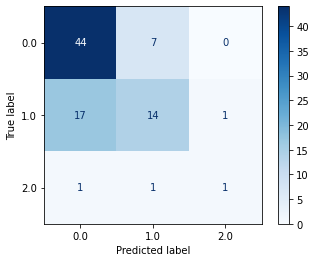

In [28]:
plot_confusion_matrix(classifier, X=X_test, y_true=y_test, cmap='Blues')


In [29]:
df.shape

(244, 7)

## <span style="color:#EF7C8E">3. Linear Regression: </span>

In [30]:
tips_encoded.loc[:, tips_encoded.columns != 'tip']

total_bill  size  tipper_type  day_Fri  day_Sat  day_Sun  day_Thur  \
key_0                                                                       
0           16.99     2          0.0      0.0      0.0      1.0       0.0   
1           10.34     3          0.0      0.0      0.0      1.0       0.0   
2           21.01     3          1.0      0.0      0.0      1.0       0.0   
3           23.68     2          1.0      0.0      0.0      1.0       0.0   
4           24.59     4          1.0      0.0      0.0      1.0       0.0   
...           ...   ...          ...      ...      ...      ...       ...   
239         29.03     3          2.0      0.0      1.0      0.0       0.0   
240         27.18     2          0.0      0.0      1.0      0.0       0.0   
241         22.67     2          0.0      0.0      1.0      0.0       0.0   
242         17.82     2          0.0      0.0      1.0      0.0       0.0   
243         18.78     2          0.0      0.0      0.0      0.0       1.0   

       sex_Female  sex_Male  smoker_No  smoker_Yes  time_Dinner  time_Lunch  
key_0                                                                        
0             1.0       0.0        1.0         0.0          1.0         0.0  
1             0.0       1.0        1.0         0.0          1.0         0.0  
2             0.0       1.0        1.0         0.0          1.0         0.0  
3             0.0       1.0        1.0         0.0          1.0         0.0  
4             1.0       0.0        1.0         0.0          1.0         0.0  
...           ...       ...        ...         ...          ...         ...  
239           0.0       1.0        1.0         0.0          1.0         0.0  
240           1.0       0.0        0.0         1.0          1.0         0.0  
241           0.0       1.0        0.0         1.0          1.0         0.0  
242           0.0       1.0        1.0         0.0          1.0         0.0  
243           1.0       0.0        1.0         0.0          1.0         0.0  

[244 rows x 13 columns]

In [31]:
tips_encoded = tips_encoded.drop('tipper_type',axis=1)
features = tips_encoded.loc[:, tips_encoded.columns != 'tip']
target = tips_encoded.loc[:, 'tip']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.35, random_state=0)

multi_lr = LinearRegression()
multi_lr.fit(X_train, y_train)
multi_predictions = multi_lr.predict(X_test)
#multi_predictions = multi_lr.predict(X_test)
all_f_score=r2_score(y_true=y_test, y_pred=multi_predictions)

print(f"R2 score for all Feature model: {all_f_score}")
y_pred=multi_predictions


R2 score for all Feature model: 0.47956228632706543


In [32]:
test_dataset2 = pd.DataFrame(X_test, columns= ['total_bill','size','day_Fri',
 'day_Sat',
 'day_Sun',
 'day_Thur',
 'sex_Female',
 'sex_Male',
 'smoker_No',
 'smoker_Yes',
 'time_Dinner',
 'time_Lunch'])

test_dataset2['Actual_tip'] = y_test.to_numpy()
test_dataset2['Predict_tip'] = multi_predictions

test_dataset2

total_bill  size  day_Fri  day_Sat  day_Sun  day_Thur  sex_Female  \
key_0                                                                      
64          17.59     3      0.0      1.0      0.0       0.0         0.0   
63          18.29     4      0.0      1.0      0.0       0.0         0.0   
55          19.49     2      0.0      0.0      1.0       0.0         0.0   
111          7.25     1      0.0      1.0      0.0       0.0         1.0   
225         16.27     2      1.0      0.0      0.0       0.0         1.0   
...           ...   ...      ...      ...      ...       ...         ...   
217         11.59     2      0.0      1.0      0.0       0.0         0.0   
40          16.04     3      0.0      1.0      0.0       0.0         0.0   
13          18.43     4      0.0      0.0      1.0       0.0         0.0   
3           23.68     2      0.0      0.0      1.0       0.0         0.0   
152         17.26     3      0.0      0.0      1.0       0.0         0.0   

       sex_Male  smoker_No  smoker_Yes  time_Dinner  time_Lunch  Actual_tip  \
key_0                                                                         
64          1.0        1.0         0.0          1.0         0.0        2.64   
63          1.0        0.0         1.0          1.0         0.0        3.76   
55          1.0        1.0         0.0          1.0         0.0        3.51   
111         0.0        1.0         0.0          1.0         0.0        1.00   
225         0.0        0.0         1.0          0.0         1.0        2.50   
...         ...        ...         ...          ...         ...         ...   
217         1.0        0.0         1.0          1.0         0.0        1.50   
40          1.0        1.0         0.0          1.0         0.0        2.24   
13          1.0        1.0         0.0          1.0         0.0        3.00   
3           1.0        1.0         0.0          1.0         0.0        3.31   
152         1.0        1.0         0.0          1.0         0.0        2.74   

       Predict_tip  
key_0               
64        2.859155  
63        3.026925  
55        2.809034  
111       1.418201  
225       3.139208  
...            ...  
217       1.941635  
40        2.722107  
13        3.208200  
3         3.179506  
152       2.858306  

[86 rows x 14 columns]

In [33]:
# calculate the tol % with math is close by passing the actual tip row value multiplied by 0.1 for 10% in the abs_tol parameter
close=[]
for x in range(len(test_dataset2)):
    close.append(math.isclose(test_dataset2.iloc[x]["Actual_tip"], test_dataset2.iloc[x]["Predict_tip"],abs_tol=test_dataset2.iloc[x]["Actual_tip"]*0.1))
# set the close column to the list    
test_dataset2['close']=close
# get the value counts
lin_preds=test_dataset2['close'].value_counts()

## <span style="color:#EF7C8E">4. Results and Final Thoughts: </span>

In [34]:
print("--"*20+" Results "+"--"*20)
print(f"The total false predictions for the logistic regression is: {log_preds[False]}")
print("--"*43)
print(f"The total false predictions for the linear regression is: {lin_preds[False]}")
print("--"*43)

---------------------------------------- Results ----------------------------------------
The total false predictions for the logistic regression is: 27
--------------------------------------------------------------------------------------
The total false predictions for the linear regression is: 65
--------------------------------------------------------------------------------------


In [42]:
print("--"*20+" Results "+"--"*20)
print(f"The % of false predictions for the logistic regression is: {round(log_preds[False]/log_preds.sum(),2)*100}%")
print("--"*43)
print(f"The % of false predictions for the linear regression is: {round(lin_preds[False]/lin_preds.sum(),2)*100}%")
print("--"*43)
print("As we can see the logistic regression has a less false count and percentage therefore it is better.")

---------------------------------------- Results ----------------------------------------
The % of false predictions for the logistic regression is: 31.0%
--------------------------------------------------------------------------------------
The % of false predictions for the linear regression is: 76.0%
--------------------------------------------------------------------------------------
As we can see the logistic regression has a less false count and percentage therefore it is better.
